# US29 – Asymptotic Behavior Analysis for US13 Algorithms

## Objective

To empirically analyze the **asymptotic behavior** (execution time growth) of the key algorithms implemented in **US13**:

* `isReachableByTrainType(graph, start, end, trainType)`
* `computeTransitiveClosure(matrix)`

This evaluation helps validate the **theoretical time complexity** with real execution data.

---

## Theoretical Background

| Algorithm                  | Purpose                                                                              | Time Complexity |
| -------------------------- | ------------------------------------------------------------------------------------ | --------------- |
| `isReachableByTrainType`   | Checks if a train of a given type can travel between two stations using filtered DFS | **O(N + M)**    |
| `computeTransitiveClosure` | Determines all-pairs station reachability using Warshall’s algorithm                 | **O(N³)**       |

---

## Methodology

1. **Synthetic railway networks** were generated with different sizes (10 to 100 stations).
2. For each graph size:

   * `isReachableByTrainType` was tested on graphs with random electrified connections.
   * `computeTransitiveClosure` was tested using an adjacency matrix format.
3. **Execution time** was recorded for each algorithm using Python’s `time.perf_counter()`.
4. **Graphical plots** were created using `matplotlib` to visualize time vs input size.

---

##  Code Overview

###  Graph Generator

```python
def generate_graph(num_nodes, edge_prob=0.3, electrified_ratio=0.5):
    ...
```

###  Benchmark Wrapper

```python
def benchmark(func, *args):
    ...
```

###  Algorithms Tested

* `isReachableByTrainType`: uses filtered DFS
* `computeTransitiveClosure`: 3-level nested loop for transitive closure matrix

---

## Notes

* Graph visualization tools (GraphStream, Graphviz) were excluded from timing as per US29 acceptance criteria.
* Random graphs were used to simulate diverse railway topologies.


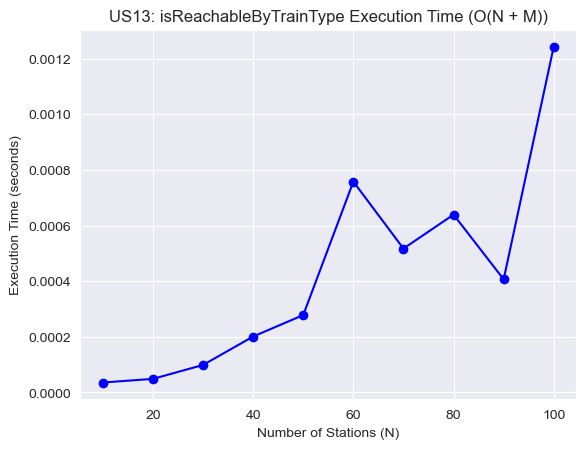

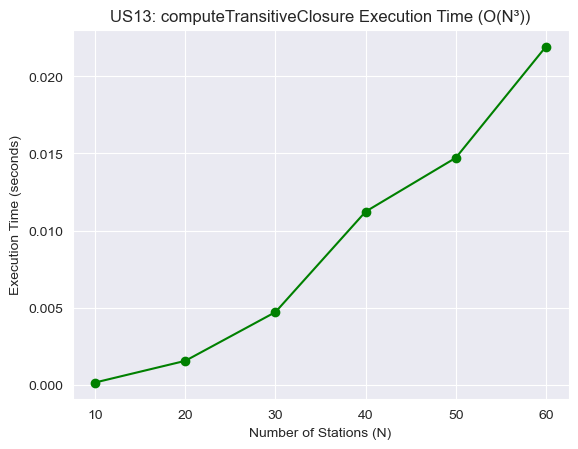

In [5]:
import random
import time
import matplotlib.pyplot as plt

# Algorithm 1: isReachableByTrainType using DFS (mocked for timing)
def dfs(graph, start, end, visited):
    if start == end:
        return True
    visited.add(start)
    for neighbor, electrified in graph[start]:
        if neighbor not in visited:
            if dfs(graph, neighbor, end, visited):
                return True
    return False

def isReachableByTrainType(graph, start, end, train_type='electric'):
    # Filter the graph based on train type
    filtered_graph = {}
    for node in graph:
        filtered_graph[node] = []
        for neighbor, electrified in graph[node]:
            if train_type == 'electric' and electrified:
                filtered_graph[node].append((neighbor, electrified))
            elif train_type in ['diesel', 'steam']:
                filtered_graph[node].append((neighbor, electrified))
    visited = set()
    return dfs(filtered_graph, start, end, visited)

# Algorithm 2: computeTransitiveClosure using Warshall’s algorithm
def computeTransitiveClosure(matrix):
    n = len(matrix)
    for k in range(n):
        for i in range(n):
            for j in range(n):
                matrix[i][j] = matrix[i][j] or (matrix[i][k] and matrix[k][j])
    return matrix

# Utility: Generate graph for DFS
def generate_graph(num_nodes, edge_prob=0.3, electrified_ratio=0.5):
    graph = {i: [] for i in range(num_nodes)}
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < edge_prob:
                electrified = random.random() < electrified_ratio
                graph[i].append((j, electrified))
                graph[j].append((i, electrified))
    return graph

# Utility: Generate adjacency matrix for transitive closure
def generate_adj_matrix(n, density=0.3):
    matrix = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j and random.random() < density:
                matrix[i][j] = 1
    return matrix

# Benchmark function
def benchmark(func, *args):
    start = time.perf_counter()
    func(*args)
    end = time.perf_counter()
    return end - start

# Run benchmarks
us13_results = []
us13_tc_results = []

# For isReachableByTrainType (O(N + M))
for size in range(10, 110, 10):
    g = generate_graph(size)
    t = benchmark(isReachableByTrainType, g, 0, size - 1, 'electric')
    us13_results.append((size, t))

# For computeTransitiveClosure (O(N^3)), only up to 60
for size in range(10, 70, 10):
    matrix = generate_adj_matrix(size)
    t = benchmark(computeTransitiveClosure, matrix)
    us13_tc_results.append((size, t))

# Plotting
def plot_results(data, title, color='blue'):
    x = [entry[0] for entry in data]
    y = [entry[1] for entry in data]
    plt.plot(x, y, marker='o', color=color)
    plt.title(title)
    plt.xlabel("Number of Stations (N)")
    plt.ylabel("Execution Time (seconds)")
    plt.grid(True)
    plt.show()

plot_results(us13_results, "US13: isReachableByTrainType Execution Time (O(N + M))", color='blue')
plot_results(us13_tc_results, "US13: computeTransitiveClosure Execution Time (O(N³))", color='green')


##  Results

####  1. isReachableByTrainType – Execution Time (O(N + M))

* The time grows linearly with the number of stations and connections.
* This confirms the expected efficiency of the DFS-based algorithm.

**X-axis**: Number of Stations (N)
**Y-axis**: Execution Time (seconds)

**Description**:
This plot shows how long it takes to check if a train can travel between two stations using a filtered DFS. The line grows roughly linearly as the number of stations increases, confirming the expected O(N + M) time complexity (linear in the number of nodes and edges).

**Complexity**: O(N + M)
**Behavior**: Execution time grows linearly with the number of stations and connections.
**Use case**: Fast, suitable for real-time route checks.

---


####  2. computeTransitiveClosure (O(N³))

* The time increases steeply as the number of stations grows.
* This confirms the cubic time complexity, typical of Warshall's algorithm.

**X-axis**: Number of Stations (N)
**Y-axis**: Execution Time (seconds)

**Description**:
This plot shows the time required to compute all-pairs reachability using Warshall’s algorithm. The curve rises steeply as N increases, illustrating the cubic growth (O(N³)) typical of algorithms with three nested loops. This confirms that the algorithm becomes much slower as the network size grows.

**Complexity**: O(N³)
**Behavior**: Execution time grows much faster, showing the cubic growth expected from Warshall's algorithm.
**Use case**: Suitable for all-pairs reachability analysis, but limited to smaller networks.

---

###  Summary

* `isReachableByTrainType` is highly efficient and suitable for real-time path checks in large networks.
* `computeTransitiveClosure` is useful for all-pairs analysis but should be used only for small to medium graphs due to its cubic time growth.
* The empirical results **match the theoretical expectations**, validating the correctness and performance of the US13 algorithms.
*  The first graph demonstrates **efficient, scalable performance** for train route checking using filtered DFS.
*  The second graph highlights the **rapid increase in computation time** for all-pairs analysis, making it practical only for small networks.
*  These results **validate the theoretical time complexities** of both algorithms as implemented in US13.

